# 1. BASIC STEPS

### 1.1. Import libaries

In [2]:
import dataloader
import models
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import time
import matplotlib.pyplot as plt
import os
import numpy as np

### 1.2. Define device

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print('The GPU to be used: {}.'.format(torch.cuda.get_device_name(0)))
else:
    print('No GPU detected.')

No GPU detected.


# 2. DATA PROCESSING

### 1.1. Load training data

In [4]:
# batch size & nclusters
batch_size = 8
nclusters = 9

# data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip()
])

# load training data
print('Load training data...', end=' ')
train_imgfolder = dataloader.PairImageFolder(root='./data/train', transform=train_transform, nclusters=nclusters)
train_loader = torch.utils.data.DataLoader(train_imgfolder, batch_size=batch_size, shuffle=True)
print('Done.')
print('Training data size: {}.'.format(len(train_imgfolder)))

Load training data... 

FileNotFoundError: [WinError 3] The system cannot find the path specified: './data/train'

### 1.2. Visualize & test input tensor

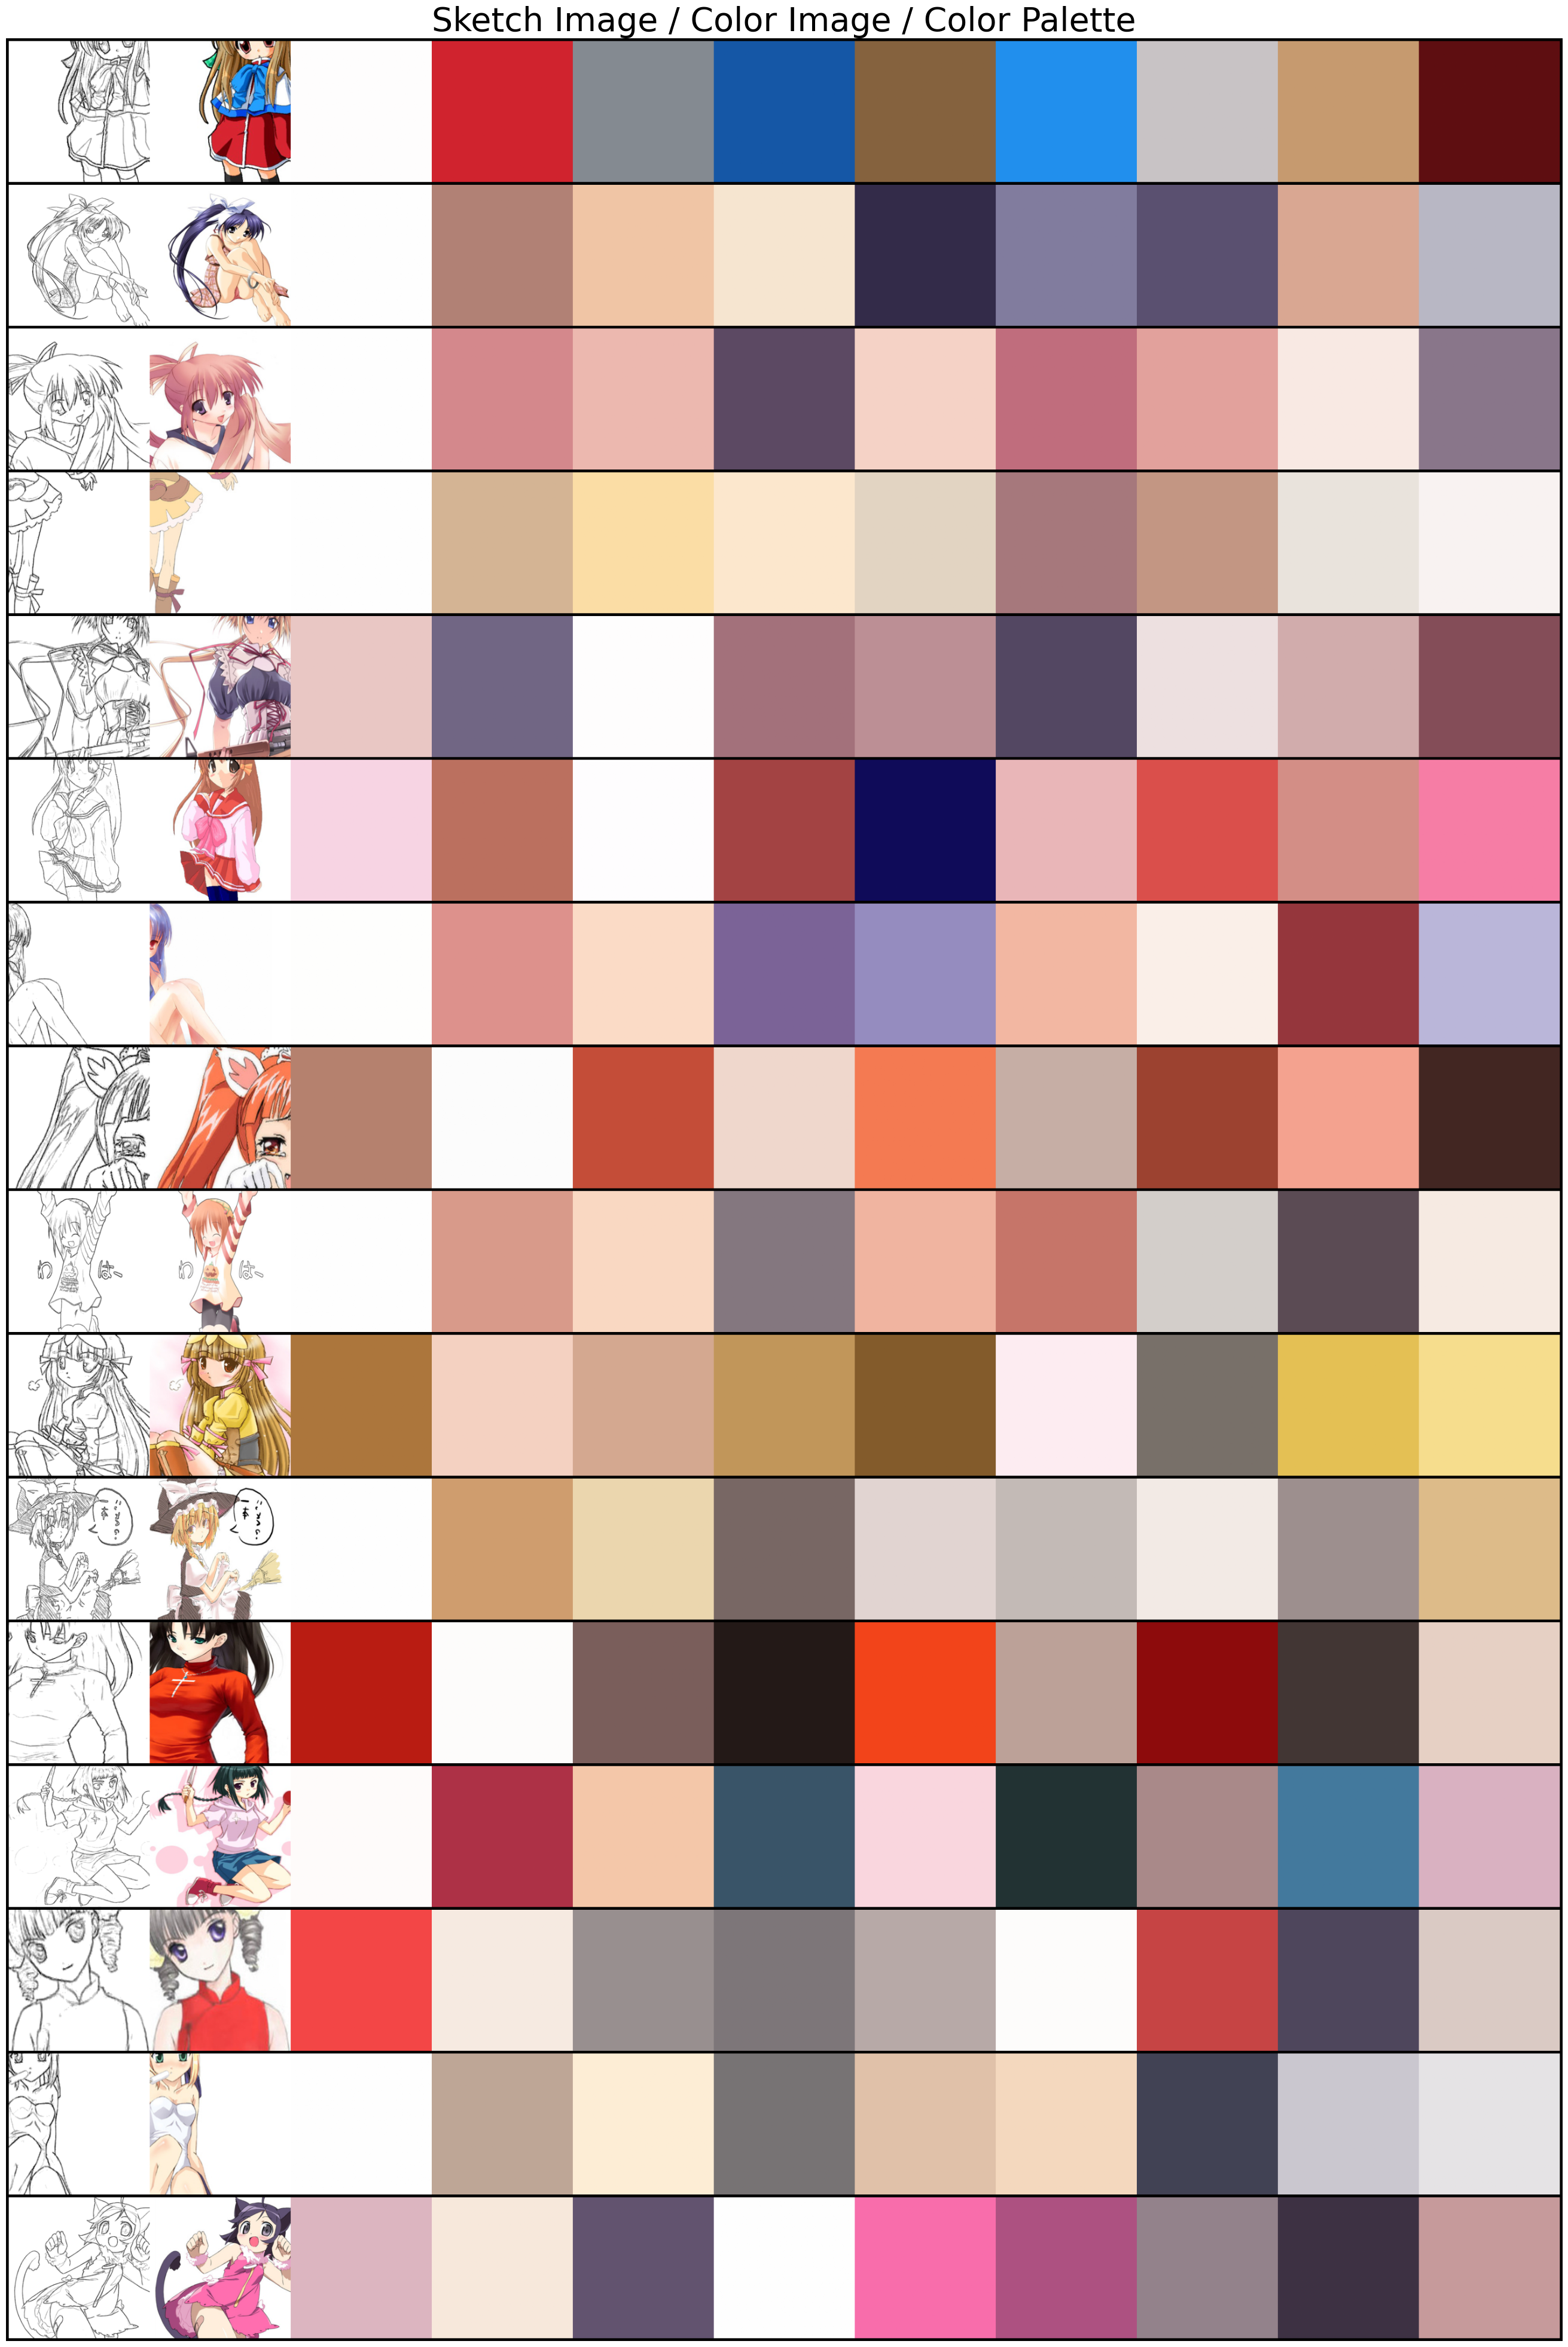

In [4]:
temp_train_batch = next(iter(train_loader))
edge_img, color_img, color_palette = temp_train_batch

# plot training data
plt.figure(figsize=(50, 50))
result = torch.cat([edge_img, color_img] + color_palette, dim=3)
plt.imshow(np.transpose(torchvision.utils.make_grid(result, nrow=1, padding=5, normalize=True),(1, 2, 0)))
plt.axis("off")
plt.title("Sketch Image / Color Image / Color Palette", fontsize=40)
plt.show()

# 3. MODELS

In [5]:
input_channels = 3 * (nclusters + 1)

# load models
netG = models.Sketch2Color(input_channels=input_channels, pretrained=False).to(device)
netD = models.Discriminator(input_channels=input_channels+3, pretrained=False).to(device)

# number of parameters
num_parameters = sum(p.numel() for p in netG.parameters() if p.requires_grad) + sum(p.numel() for p in netD.parameters() if p.requires_grad)
print('Number of parameters: {}.'.format(num_parameters))

# cudnn optimization enabled
torch.backends.cudnn.benchmark = True

Weights of Generator model are initialized.
Weights of Discriminator model are initialized.
Number of parameters: 113683623.


In [6]:
netEx = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT).features[0:4].to(device)

# 4. MODEL TRAINING

### 4.1. Setup hyparameters 

In [7]:
# number of epochs
epochs = 30

# learning rate
lr = 2e-4

# betas 
beta1 = 0.5
beta2 = 0.999

# Adam optimizer 
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))

### 4.2. Set up loss functions

In [8]:
class TotalVarienceLoss(nn.Module):
    def __init__(self, weight=1.0):
        super().__init__()
        self.weight = weight

    def forward(self, x):
        b, c, h, w = x.size()
        h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :-1, :], 2).sum()
        w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :-1], 2).sum()
        return self.weight * (h_tv + w_tv) / (b * c * h * w)

In [ ]:
# loss functions
criterion_L1 = torch.nn.L1Loss() # L1 loss
criterion_fm = torch.nn.MSELoss() # feature matching loss
criterion_tv = TotalVarienceLoss() # total varience loss
criterion_adv = torch.nn.BCELoss() # adversarial loss

# lambda 
lambda1 = 100
lambda2 = 1e-2
lambda3 = 1e-4
lambda4 = 1

### 4.3. Load validation data to visualize 

In [10]:
# number of img to visualize
visual_size = 6

val_transform = transforms.Compose([
    transforms.Resize(256)
])

# load validation data
print('Load validation data...', end=' ')
val_imgfolder = dataloader.PairImageFolder(root='./data/val', transform=val_transform, nclusters=nclusters)
val_loader = torch.utils.data.DataLoader(val_imgfolder, batch_size=visual_size, shuffle=True)
print('Done.')
print('Validation data size: {}.'.format(len(val_imgfolder)))

Load validation data... Done.
Validation data size: 10.


In [11]:
# visualize val img through each epoch
temp_val_batch = next(iter(val_loader))
val_edge = temp_val_batch[0].to(device)
val_color = temp_val_batch[1].to(device)
val_color_palette = temp_val_batch[2]
val_input = torch.cat([val_edge.cpu()] + val_color_palette, dim=1).to(device)

### 4.4. Set up Wabdb

In [ ]:
wandb.log()

In [ ]:
wandb.init(project="image-colorization2")

wandb.config.update({
    "epochs": epochs,
    "lambda1": lambda1,
    "lambda2": lambda2,
    "lambda3": lambda3,
    "dambda4": lambda4
})

### 4.5. Traning loop

In [ ]:
netD.train()
netG.train()

best_loss = float('inf')

print('Starting training loop...')
for epoch in range(epochs):

    for i, data in enumerate(train_loader, 0):
        # Set input 
        edge = data[0].to(device)
        color = data[1].to(device)
        color_palette = data[2]
        input_tensor = torch.cat([edge.cpu()] + color_palette, dim=1).to(device)
        batch_size = input_tensor.size(0)

        # Real & fake label
        real_label = torch.full((batch_size, 1), 0.9, device=device, requires_grad=False)
        fake_label = torch.full((batch_size, 1), 0.0, device=device, requires_grad=False)
        
        ##### Discriminator #####
        
        # Output
        fake = netG(input_tensor)
        predict_fake = netD(input_tensor, fake)
        predict_real = netD(input_tensor, color)

        # Optimize
        optimizerD.zero_grad()

        # Loss
        lossD = criterion_adv(predict_fake, fake_label) + criterion_adv(predict_real, real_label)

        # Update
        lossD.backward()
        optimizerD.step()

        ###### Generator #######

        # Output
        fake = netG(input_tensor)
        predict_fake = netD(input_tensor, fake)
        predict_real = netD(input_tensor, color)
        fake_feature = netEx(fake)
        real_feature = netEx(color)

        # Optimize
        optimizerG.zero_grad()

        # Loss
        loss_L1 = criterion_L1(fake, color)
        loss_fm = criterion_fm(fake_feature, real_feature)
        loss_tv = criterion_tv(fake)
        loss_adv = criterion_adv(predict_fake, real_label)

        lossG = lambda1 * loss_L1 + lambda2 * loss_fm + lambda3 * loss_tv + lambda4 * loss_adv

        # Update
        lossG.backward()
        optimizerG.step()

    if best_loss > lossG.item():
        best_loss = lossG.item()
        state = {
            'epoch': epoch,
            'netG': netG.state_dict(),
            'netD': netD.state_dict(),
            'optimizerG': optimizerG.state_dict(),
            'optimizerD': optimizerD.state_dict(),
            'best_loss': best_loss
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')

    # visualize validation after each epoch 
    with torch.no_grad():
        fake = netG(val_input)

    table = wandb.Table(columns=["Ground Truth", "Generated Image"])
    for j in range(visual_size):
        fake_img = fake[j].detach().cpu().numpy()  
        fake_img = ((fake_img + 1) / 2).clip(0, 1).transpose(1, 2, 0)  

        real_img = val_color[j].detach().cpu().numpy()
        real_img = ((real_img + 1) / 2).clip(0, 1).transpose(1, 2, 0)
       
        table.add_data(wandb.Image(real_img), wandb.Image(fake_img))

    wandb.log({
        "LossD": lossD.item(),
        "LossG": lossG.item(),
        "Loss_L1": loss_L1.item(),
        "Loss_fm": loss_fm.item(),
        "Loss_tv": loss_tv.item(),
        "Loss_adv": loss_adv.item(),
        f"Epoch {epoch}": table
    })

    print('Epoch[{0}/{1}]\nLossD: {2:.2f}, lossG: {3:.2f}, loss_L1: {4:.2f}, loss_fm: {5:.2f}, loss_tv: {6:.2f}, loss_adv: {7:.2f}.'.format(
           epoch, epochs, lossD.item(), lossG.item(), loss_L1.item(), loss_fm.item(), loss_tv.item(), loss_adv.item()))
    
print('\nDone.')

In [28]:
# batch size & nclusters
batch_size = 1
nclusters = 9

# data augmentation
val_transform = transforms.Compose([
    transforms.Resize(256)
])

# load val data
print('Load val data...', end=' ')
val_imgfolder = dataloader.PairImageFolder(root='./data/val', transform=val_transform, nclusters=nclusters)
val_loader = torch.utils.data.DataLoader(val_imgfolder, batch_size=batch_size, shuffle=True)
print('Done.')
print('Val data size: {}.'.format(len(val_imgfolder)))

Load val data... Done.
Val data size: 1.


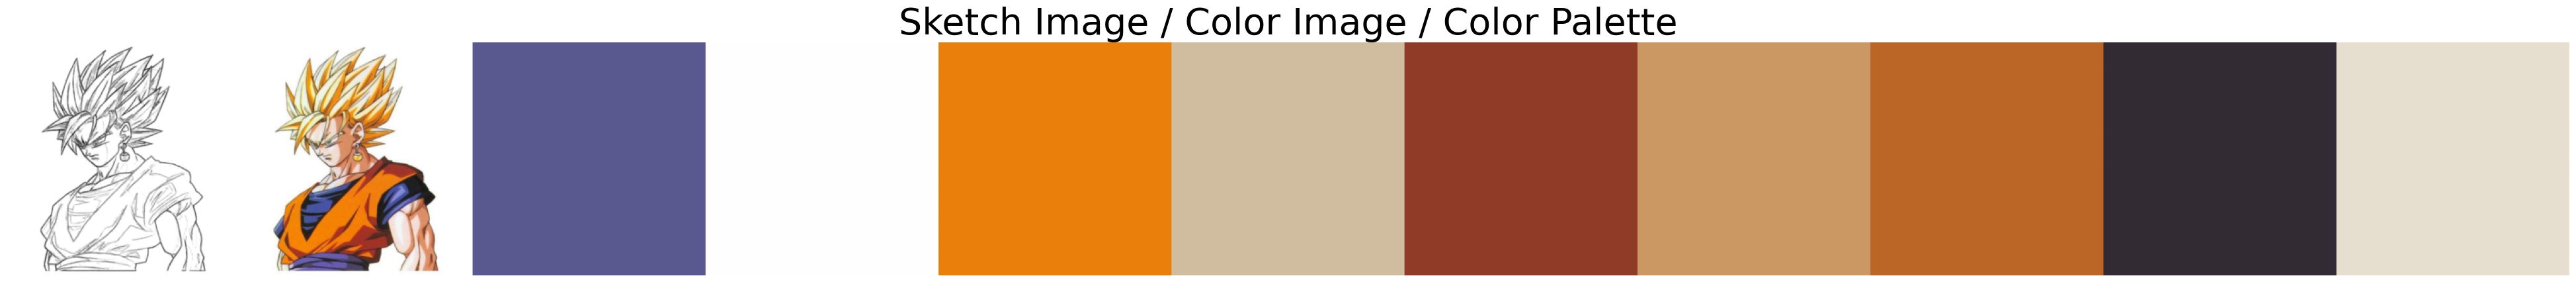

In [29]:
temp_val_batch = next(iter(val_loader))
edge_img, color_img, color_palette = temp_val_batch
input_edge = edge_img
ground_truth = color_img

# plot val data
plt.figure(figsize=(50, 50))
result = torch.cat([edge_img, color_img] + color_palette, dim=3)
plt.imshow(np.transpose(torchvision.utils.make_grid(result, nrow=1, padding=5, normalize=True),(1, 2, 0)))
plt.axis("off")
plt.title("Sketch Image / Color Image / Color Palette", fontsize=40)
plt.show()

In [30]:
# batch size & nclusters
batch_size = 1
nclusters = 9

# data augmentation|
ref_transform = transforms.Compose([
    transforms.Resize(256)
])

# load ref data
print('Load ref data...', end=' ')
ref_imgfolder = dataloader.PairImageFolder(root='./data/reference', transform=ref_transform, nclusters=nclusters)
ref_loader = torch.utils.data.DataLoader(ref_imgfolder, batch_size=batch_size, shuffle=True)
print('Done.')
print('Ref data size: {}.'.format(len(ref_imgfolder)))

Load ref data... Done.
Ref data size: 1.


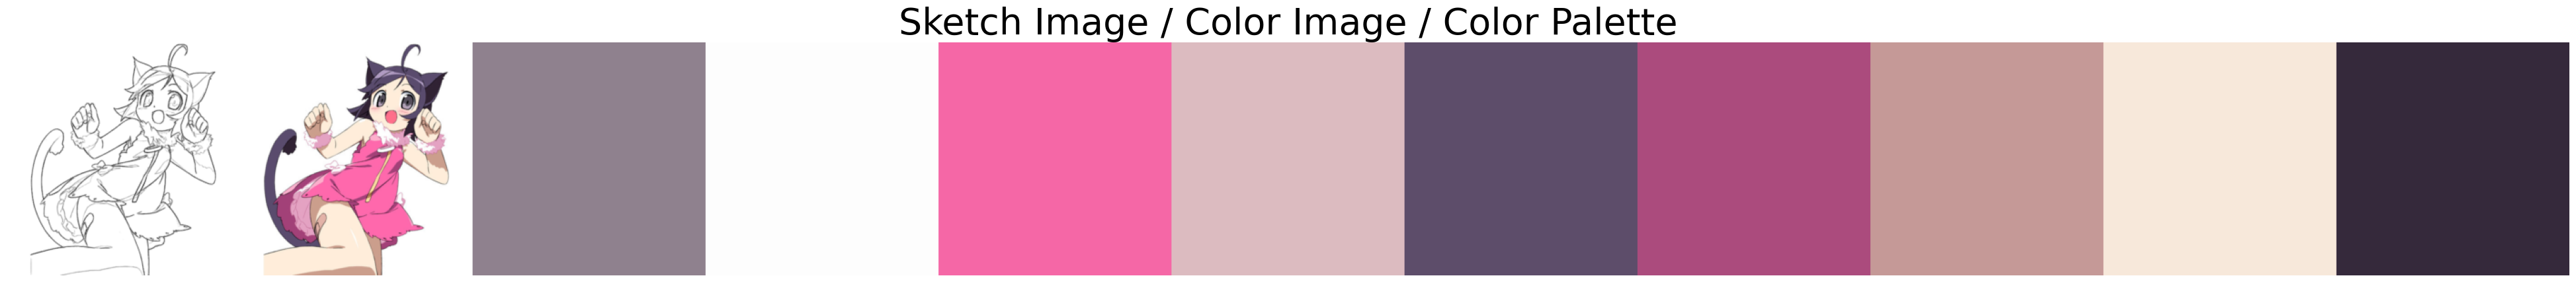

In [31]:
temp_ref_batch = next(iter(ref_loader))
edge_img, color_img, color_palette = temp_ref_batch
input_color_palette = color_palette
ref_color_img = color_img

# plot val data
plt.figure(figsize=(50, 50))
result = torch.cat([edge_img, color_img] + color_palette, dim=3)
plt.imshow(np.transpose(torchvision.utils.make_grid(result, nrow=1, padding=5, normalize=True),(1, 2, 0)))
plt.axis("off")
plt.title("Sketch Image / Color Image / Color Palette", fontsize=40)
plt.show()

In [32]:
input_edge = input_edge.to(device)
ref_color_img = ref_color_img.to(device)
input_color_palette = input_color_palette
input_tensor = torch.cat([input_edge.cpu()] + input_color_palette, dim=1).to(device)
ref = torch.cat(input_color_palette, dim=1).to(device)

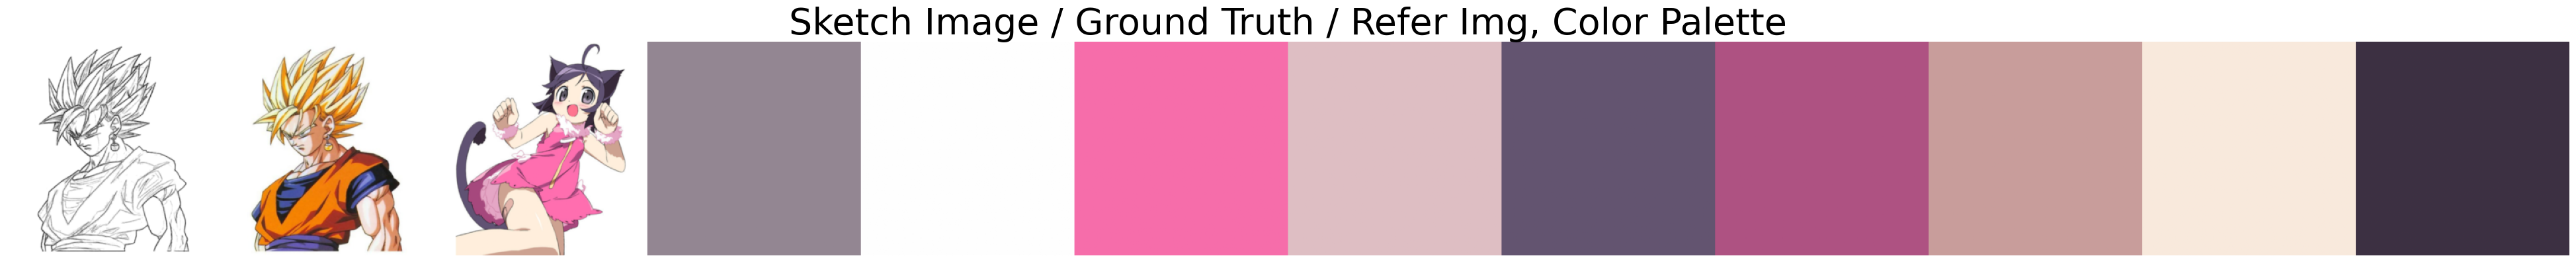

In [33]:
plt.figure(figsize=(50, 50))
result = torch.cat([input_edge, ground_truth, ref_color_img] + input_color_palette, dim=3)
plt.imshow(np.transpose(torchvision.utils.make_grid(result, nrow=1, padding=5, normalize=True),(1, 2, 0)))
plt.axis("off")
plt.title("Sketch Image / Ground Truth / Refer Img, Color Palette", fontsize=40)
plt.show()

Weights of Generator model are initialized.


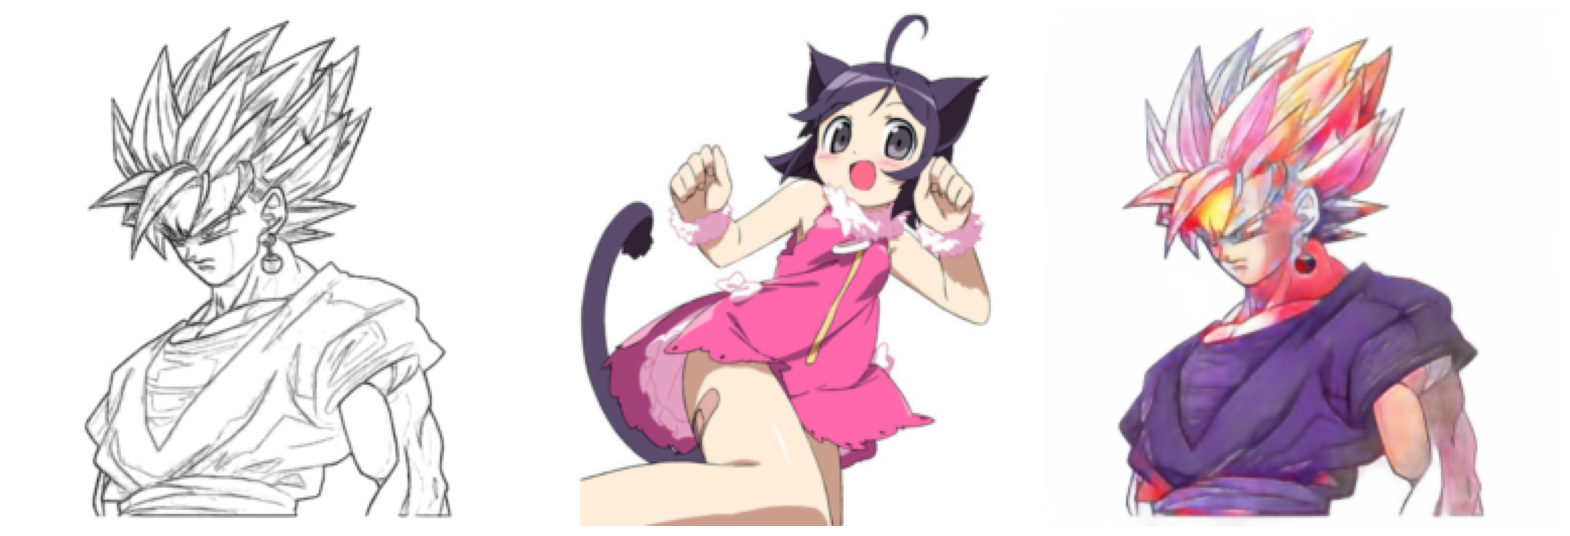

In [34]:
with torch.no_grad():
    netG = models.Sketch2Color(30)
    checkpoint = torch.load('./checkpoint/ckpt.pth', map_location="cpu")
    netG.load_state_dict(checkpoint['netG'], strict=True)
    fake = netG(input_tensor)
    plt.figure(figsize=(20, 20))
    result = torch.cat([input_edge, ref_color_img, fake], dim=3)
    plt.imshow(np.transpose(torchvision.utils.make_grid(result, nrow=1, padding=5, normalize=True), (1, 2, 0)))
    plt.axis("off")
    plt.show()